## Calculate Cn2 From a Part of the Video

In [1]:
import numpy as np
import cv2
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

c:\Users\Ripon Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Ripon Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Ripon Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
c:\Users\Ripon Lab\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Read all the frames

In [2]:
# Create a VideoCapture object
path = "Stabilized Road.mp4"
cap = cv2.VideoCapture(path)

# x, y, w, h = 540, 200, 200, 200
x, y, w, h = 0, 0, 1920, 1080
 
video = []

# Check if camera opened successfully
if (cap.isOpened() == False): 
  print("Unable to read camera feed")
 
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
# out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (w,h))

while(True):
  ret, frame = cap.read()
 
  if ret == True: 
    frame = frame[y:y+h, x:x+w]
    video.append(frame)
    # out.write(frame)
  else:
    break 
 
# When everything done, release the video capture and video write objects
cap.release()
# out.release()

(476, 1080, 1920, 3)


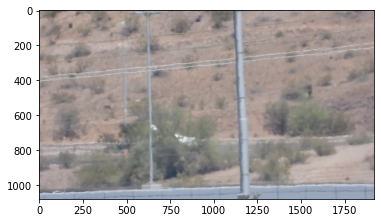

In [3]:
video = np.array(video)
print(video.shape)
plt.imshow(video[475][:,:,::-1]), 
plt.show()

### Calculate the Image Gradient

In [4]:
def imgradient(img):
    if type(img) != np.ndarray:
        img = img.convert('L')
        img = np.asarray(img)

    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = cv2.filter2D(img, -1, sobel_x)
    Gy = cv2.filter2D(img, -1, sobel_y)
    grad_mag = np.sqrt(Gx**2 + Gy**2)
    return grad_mag

### Function for Turbulence strength calculation

In [5]:
def fcn_Cnsqr_sequence(data, PFOV, D, L, P):
    sigma_I = np.std(data, axis=0)
    Cn_sqr_vec = []
    for iSequence in range(data.shape[0]):
        d = data[iSequence,:,:]
        Grad_mag = imgradient(d)
        Grad_mag[Grad_mag < Grad_mag.max()/100] = np.nan
        Cn_sqr_mn = np.divide((np.dot(PFOV**2, D**(1/3)) * sigma_I**2), (Grad_mag*float(L)*float(P)))
        Cn_sqr_vec.append(np.nanmean(Cn_sqr_mn))
    return np.nanmean(Cn_sqr_vec)

### Compute the Time interval and unique time

In [6]:
focal_length, fstop = 0.5, 8.000
D, ImageScalledDown, lambda_temp, L = focal_length/fstop, 3, 500E-9, 2789
dx, dy = ImageScalledDown*0.003208/1000, ImageScalledDown*0.003208/1000
PFOV, l_0, L_0 = dx/np.array(focal_length), 1 / 1000, 80
P = 2.914 if D < np.sqrt(lambda_temp * L) and l_0 <= D < L_0 else 1.1

print(f'{PFOV=}, {D=}, {L=}, {P=}')

PFOV=1.9248000000000003e-05, D=0.0625, L=2789, P=1.1


### Estimate the Turbulence intensity

1. Top ->      3.88e-13
2. Bottom ->   9.22e-13
2. Bottom-Left ->7.59e-13
2. Bottom Right -> 10e-13

cn2=6.533445254674862e-13


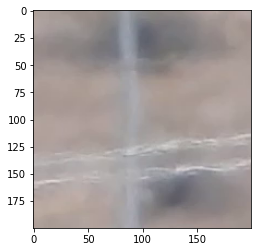

In [7]:
# t, h, w, ch
x, y = 540, 200
h, w = 200, 200
plt.imshow(video[0, y:y+h, x:x+w, ::-1]);

data = video[:, y:y+h, x:x+w, 0]
cn2 = fcn_Cnsqr_sequence(data, PFOV, D, L, P)
print(f'{cn2=}')